In [23]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from io import BytesIO
from textwrap import fill
from zipfile import ZipFile
from urllib.request import urlopen
from matplotlib.ticker import FormatStrFormatter

In [54]:
# CONFIGURAÇÃO DE RESOLUÇÃO

# - Em caso de utilização dos gráficos gerados neste notebook
# para apresentação externa, i.e. download das imagens, descomente
# e execute linha de código abaixo. Caso deseje visualizá-los adequadamente
# dentro deste notebook, mantenha-a inalterada ou altere o valor para 72 (padrão).

%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

mpl.rcParams['figure.dpi'] = 288

####Seleção e pré-processamento dos dados



In [25]:
#ENADE_2021_URL = "https://github.com/EudeMonteiro/KDD-Enade-UFPA-Courses/raw/main/microdados2021_arq3.zip"
ENADE_2017_URL = "https://github.com/renan-cunha/EnadeData/raw/main/microdados_enade_2017.zip"

UFPA_CODE = 569
PRESENT_STUDENT_CODE = 555
NUM_SK_QUESTIONS = 27 #Número de questões da componente de conhecimento específico
PUBLIC_ADMIN_CATEGORY = 1 # Categoria administrativa: pública
FEDERAL_ORG_CATEGORY = 10028 # Categoria organizacional: universidade

# Dicionário de códigos de cursos
# Seguem a estrutura:
# {<Código de área>: [<Nome do curso>, <Abreviação>, <Código do curso da UFPA>]}
COURSE_CODES = {4004: ["Ciência da Computação", "CC", 12025],
                1401: ["Física (Bacharelado)", "FIS_BAC", 12000],
                1402: ["Física (Licenciatura)", "FIS_LIC", 12022],
                702:  ["Matemática (Licenciatura)", "MAT", 11999],
                1501: ["Química (Bacharelado)", "QUIM_BAC", 12007],
                1502: ["Química (Licenciatura)", "QUIM_LIC", 12026],
                4006: ["Sistemas de Informação", "SI", 60886]
                }

QUESTIONS_SUBJECTS_URL = "https://raw.githubusercontent.com/EudeMonteiro/KDD-Enade-UFPA-Courses/main/databases/"
HEI_CODES_URL = "https://raw.githubusercontent.com/EudeMonteiro/KDD-Enade-UFPA-Courses/main/databases/hei.csv"

DTYPES = {"DS_VT_ACE_OFG" : str,
          "DS_VT_ACE_OCE" : str,
          "DS_VT_ESC_OCE" : str,
          "DS_VT_ESC_OFG" : str}


def get_raw_data(url: str, extract_to: str = '.') -> None:
    """
    Realiza o download dos microdados hospedados em repositórios externos.

    Parameters
    ----------
    url : str
        A URL do arquivo ZIP contendo os microdados.
    extract_to : str, optional
        O diretório de extração dos microdados. O padrão é o diretório atual.

    Returns
    -------
    None

    Raises
    ------
    urllib.error.URLError
        Se ocorrer um erro ao fazer o download do arquivo.
    zipfile.BadZipFile
        Se o arquivo ZIP estiver corrompido ou inválido.

    Examples
    --------
    >>> get_raw_data('https://example.com/microdados.zip', '.')
    """

    # Faz o download do arquivo ZIP
    http_response = urlopen(url)

    # Extrai o conteúdo do arquivo ZIP
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=extract_to)


def filter_courses_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filtra somente os participantes presentes na prova, que tiveram resultado
    válido e que preencheram o cartão-resposta do exame.

    Parameters
    ----------
    df : pandas.DataFrame
        O DataFrame contendo os dados dos participantes.

    Returns
    -------
    pandas.DataFrame
        O DataFrame filtrado com os participantes que atendem aos critérios.

    Examples
    --------
    Exemplo de uso:

    >>> filtered_df = filter_courses_results(df)
    """

    df = df.loc[df["CO_GRUPO"].isin(COURSE_CODES.keys())]
    df = df.loc[(df["TP_PRES"] == PRESENT_STUDENT_CODE) &
                (df["TP_PR_GER"] == PRESENT_STUDENT_CODE) &
                (~df["DS_VT_ESC_OCE"].isna())]

    return df


def reduce_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Seleciona os atributos relevantes para a realização da análise dos dados.

    Parameters
    ----------
    df : pandas.DataFrame
        O DataFrame contendo os dados completos.

    Returns
    -------
    pandas.DataFrame
        O DataFrame reduzido contendo somente os atributos relevantes.

    Examples
    --------
    Exemplo de uso:

    >>> reduced_df = reduce_data(df)
    """

    columns = ["NU_ANO",
               "CO_IES",
               "CO_GRUPO",
               "CO_CURSO",
               "CO_CATEGAD",
               "CO_ORGACAD",
               "DS_VT_ACE_OCE",
               "DS_VT_ACE_OFG",
               "DS_VT_ESC_OCE",
               "NT_CE",
               "NT_GER",
               "NT_OBJ_CE",
               "TP_PRES",
               "TP_PR_GER",
               "QE_I08",
               "QE_I23"]

    return df[columns]


if __name__ == '__main__':

    get_raw_data(url=ENADE_2017_URL, extract_to='.')
    raw_data = pd.read_csv("/content/3.DADOS/MICRODADOS_ENADE_2017.txt", sep=";", decimal=",", dtype=DTYPES)
    selected_data = filter_courses_results(raw_data)
    Enade_2017 = reduce_data(selected_data)


####Funções auxiliares de limpeza e mineração de dados

In [47]:
def get_subjects_per_question(questions_subjects_df: pd.DataFrame) -> pd.Series:
    """
    Retorna a contagem de ocorrências de cada assunto nas questões.

    Parameters
    ----------
    questions_subjects_df : pandas.DataFrame
        O DataFrame contendo os assuntos das questões.

    Returns
    -------
    pandas.Series
        A contagem de ocorrências de cada assunto nas questões.

    Examples
    --------
    >>> subjects_counts = get_subjects_per_question(questions_subjects_df)
    """

    subjects_columns = ["FIRST_SUBJECT", "SECOND_SUBJECT", "THIRD_SUBJECT"]

    subjects_per_question = (
        questions_subjects_df[subjects_columns]
        .stack()
        .value_counts()
        .sort_index()
        .astype(int)
    )

    return subjects_per_question.values


def get_invalid_subjects(questions_subjects_df: pd.DataFrame) -> list:
    """
    Retorna a lista de assuntos inválidos nas questões.

    Parameters
    ----------
    questions_subjects_df : pandas.DataFrame
        O DataFrame contendo os assuntos das questões e sua validade.

    Returns
    -------
    list
        A lista de assuntos inválidos nas questões.

    Examples
    --------
    Exemplo de uso:

    >>> invalid_subjects_list = get_invalid_subjects(questions_subjects_df)
    """

    invalid_subjects = questions_subjects_df.groupby("FIRST_SUBJECT")["VALIDITY"].any()
    invalid_subjects = invalid_subjects[~invalid_subjects].index.tolist()
    return invalid_subjects


def get_score_per_subject(questions_subjects_df: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna a pontuação por assunto com base nas respostas dos participantes.

    Parameters
    ----------
    questions_subjects_df : pandas.DataFrame
        O DataFrame contendo os assuntos das questões.
    df : pandas.DataFrame
        O DataFrame contendo as respostas dos participantes.

    Returns
    -------
    pandas.DataFrame
        O DataFrame com a pontuação por assunto.

    Examples
    --------
    Exemplo de uso:

    >>> score_per_subject_df = get_score_per_subject(questions_subjects_df, df)
    """

    # Obtém uma lista de todos os temas distintos
    subjects = questions_subjects_df[["FIRST_SUBJECT","SECOND_SUBJECT","THIRD_SUBJECT"]].values.ravel('K')
    subjects = pd.Series(subjects).dropna().sort_values().unique()

    # Inicializa o DataFrame para armazenar os resultados dos assuntos
    subjects_score = pd.DataFrame({"Conteúdo" : subjects, "Acertos" : 0})

    # Colunas de questões relevantes
    question_columns = ["DS_VT_ACE_OCE", "DS_VT_ACE_OFG"]

    # Seleciona as respostas marcadas pelos participantes
    marked_keys = df[question_columns[0]]

    # Itera sobre as linhas do DataFrame de assuntos e contabilizar os acertos
    for index in range(questions_subjects_df.shape[0]):
        # Obtém os temas relacionados a uma questão específica
        subject_columns = questions_subjects_df.loc[index, ["FIRST_SUBJECT", "SECOND_SUBJECT", "THIRD_SUBJECT"]]
        subjects_to_update = subject_columns.dropna().values

        # Contabiliza os acertos para o(s) tema(s) relacionado(s) à questão atual
        result = marked_keys[marked_keys.str[index] == '1'].shape[0]
        subjects_score.loc[subjects_score["Conteúdo"].isin(subjects_to_update), "Acertos"] += result

    # Calcula a nota em porcentagem para cada tema
    subjects_per_question = get_subjects_per_question(questions_subjects_df)
    subject_score_column = subjects_score["Acertos"] * 100 / (subjects_per_question * df.shape[0])
    subjects_score["Nota (%)"] = subject_score_column.round(2)

    # Identifica e remove temas inválidos
    invalid_subjects = get_invalid_subjects(questions_subjects_df)
    subjects_score = subjects_score[~subjects_score["Conteúdo"].isin(invalid_subjects)]

    return subjects_score

####Visualização gráfica

In [57]:
def plot_performance_graph(group_code: int, ratio_graph=True, absolute_graph=True) -> None:
    """
    Cria e exibe gráficos de comparação de desempenho entre a UFPA
    e o Brasil para um curso específico no ENADE 2017.

    Parameters
    ----------
    group_code : int
        Código do grupo de cursos a ser analisado.
    ratio_graph : bool, optional
        Indica se o gráfico de razão de acerto deve ser exibido. O padrão é True.
    absolute_graph : bool, optional
        Indica se o gráfico de percentual de acerto absoluto deve ser exibido. O padrão é True.

    Returns
    -------
    None

    Examples
    --------
    >>> plot_performance_graph(4006)
    """
    sk_national_df = Enade_2017[Enade_2017["CO_GRUPO"] == group_code]
    sk_ufpa_df = sk_national_df[sk_national_df["CO_CURSO"] == COURSE_CODES[group_code][2]]
    questions_subjects_df = pd.read_csv(QUESTIONS_SUBJECTS_URL + COURSE_CODES[group_code][1] + "_questions_subjects.csv")

    subject_score_ufpa  = get_score_per_subject(questions_subjects_df, sk_ufpa_df)
    subject_score_national = get_score_per_subject(questions_subjects_df, sk_national_df)

    merged_score_df = pd.DataFrame({"Nota UFPA (%)":  subject_score_ufpa["Nota (%)"],
                                    "Nota Enade (%)": subject_score_national["Nota (%)"]
                                    }).set_index(subject_score_national["Conteúdo"])

    # Função lambda para calcular razão de acerto
    ratio = lambda col: (col["Nota UFPA (%)"] / col["Nota Enade (%)"]).round(2)
    merged_score_df["Razão"] = merged_score_df.apply(ratio, axis=1)

    # Configurações de formatação do gráfico
    plt.rcParams.update({"text.usetex": True})
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16



    if ratio_graph:
        title = f"Razão do percentual de acerto UFPA-Brasil em {COURSE_CODES[group_code][0]} por tema no Enade 2017"

        fig, ax = plt.subplots(figsize=(8,8))

        ax.spines[['top', 'right']].set_visible(False)
        ax.axvline(x=1.0, color="red")
        ax.grid(axis = 'x', color ='white', linestyle='-')
        ax.set_xlabel("Razão do percentual de acerto")

        merged_score_df.sort_values(by = ["Razão"], inplace=True)
        labels = [fill(x, len(x)/2 + 5) if len(x) > 60 else x for x in merged_score_df.index]

        plt.barh(labels, merged_score_df["Razão"], color = 'k', height=0.6)
        r = .2
        min_xlim = round(min(merged_score_df["Razão"]) / r) * r
        xticks = np.linspace(min_xlim - r, 2 - min_xlim + r, 9)
        ax.set_xticks(xticks)
        ax.set_xticklabels(list(map(str, xticks)))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        for tick_label in ax.get_yticklabels():
            if "\n" in tick_label.get_text():
                tick_label.set_fontsize(15)

        if subject_score_national.shape[0] > 16:
            fig.set_size_inches(8, 12)

        plt.xlim(min_xlim-r, 2 - min_xlim+r)
        plt.show()


    if absolute_graph:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.spines[['top', 'right']].set_visible(False)
        ax.grid(axis = 'x', color ='white', linestyle='-')
        ax.set_xlabel("Percentual de acerto")

        title = f"Percentual de acerto por tema em {COURSE_CODES[group_code][0]} no Enade 2017"

        ind = np.arange(merged_score_df.shape[0])
        width = 0.35

        merged_score_df.sort_values(by = ["Nota UFPA (%)", "Razão"], ascending=False, inplace=True)
        labels = [fill(x, len(x)/2 + 5) if len(x) > 60 else x for x in merged_score_df.index]

        ax.barh(ind, merged_score_df["Nota UFPA (%)"], width, color='dodgerblue', label = "UFPA")
        ax.barh(ind + width, merged_score_df["Nota Enade (%)"], width,
                color='mediumspringgreen', label = "Brasil")

        ax.set(yticks=ind+(width/2), yticklabels=labels)
        ax.legend(fontsize="large", loc='lower right', fancybox=True, shadow=True)

        for tick_label in ax.get_yticklabels():
            if "\n" in tick_label.get_text():
                tick_label.set_fontsize(15)

        if subject_score_national.shape[0] > 16:
            fig.set_size_inches(8, 12)

        plt.xlim(0,100)
        plt.gca().invert_yaxis()
        #fig.savefig("absolute_graph.pdf", format='pdf', dpi=300)
        plt.show()
        print()

        return

In [58]:
def plot_income_grade_graph(group_code:int) -> None:
    """
    Exibe um gráfico de correlação entre a renda
    familiar do discente e sua nota geral no exame.

    Parameters:
    ----------
    group_code : int
        Código do grupo a ser analisado.

    Returns:
    -------
    None

    Examples:
    -------
    >>> plot_income_grade_graph(4006)
    """

    # Filtra o DataFrame Enade_2017 pelo código do curso
    df_ufpa = Enade_2017[(Enade_2017["CO_CURSO"] == COURSE_CODES[group_code][2])]

    # Seleciona as colunas 'QE_I08' e 'NT_GER' e remove linhas com valores ausentes
    df_ufpa = df_ufpa[["QE_I08", "NT_GER"]].dropna()

    # Filtra o DataFrame df_ufpa para incluir apenas
    # categorias selecionadas por mais de um estudante
    df_ufpa = df_ufpa[df_ufpa['QE_I08'].map(df_ufpa['QE_I08'].value_counts()) > 1]

    fig, ax = plt.subplots(figsize=(8, 8))

    custom_dict = dict(linewidth=1.3)
    df_ufpa.boxplot(column=['NT_GER'], by='QE_I08', ax=ax,
                    color='black', medianprops=dict(color='orange', linewidth=2),
                    boxprops=custom_dict,
                    whiskerprops=custom_dict,
                    capprops=custom_dict,
                    flierprops=dict(markersize=10))

    ax.set_ylim(0, 100)
    ax.set_xlabel("Categoria de renda")
    ax.set_ylabel("Nota geral (\%)")

    title = f"Correlação entre nota geral e renda familiar\n\
    em {COURSE_CODES[group_code][0]} no Enade 2017"

    plt.grid(True, linestyle='--', zorder=0)
    plt.suptitle(title, fontsize=22)
    plt.title("")
    plt.show()
    print()

    return

In [59]:
def plot_study_hours_income_graph(group_code: int) -> None:
    """
    Plota um gráfico de barras mostrando a relação entre as categorias de
    renda e as horas de estudo semanais dos estudantes do curso especificado.

    Parameters:
    -----------
    group_code : int
        Código do grupo do curso a ser analisado.

    Returns:
    --------
    None

    Examples:
    --------
    >>> plot_study_hours_income_graph(4006)
    """
    # Filtrando o DataFrame com base no código do curso
    df = Enade_2017[(Enade_2017["CO_CURSO"] == COURSE_CODES[group_code][2])]

    # Agrupando por categorias de renda e horas de estudo
    grouped = df.groupby(['QE_I08', 'QE_I23']).size().unstack()
    grouped = grouped.fillna((grouped.max().max() + 1) / 300)
    filtered_grouped = grouped[grouped.sum(axis=1) > 1] # Seleção de categorias com mais de uma resposta

    colors = ['#443983', '#31688e', '#21918c', '#35b779', '#90d743']

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = grouped.plot.bar(rot=0, color=colors, width=0.8, zorder=2, ax=ax)
    ax.spines[['top', 'right']].set_visible(False)

    # Formatando o eixo y para inteiros
    num_intervals = 10
    y_range = grouped.max().max() - grouped.min().min()
    interval_size = np.ceil(y_range / num_intervals)

    # Calculando as posições dos ticks e labels
    tick_positions = np.arange(0, grouped.max().max() + 1, interval_size)
    tick_labels = [str(int(pos)) for pos in tick_positions]


    # Determinação das posições dos ticks e labels no eixo y
    ax.set_yticks(tick_positions)
    ax.set_yticklabels(tick_labels)
    ax.set_ylim(bottom=0)

    # Adicionando grade com estilo de linha pontilhado
    plt.grid(True, axis='y', linestyle='--',zorder=1)

    # Definindo rótulos dos eixos x e y, e título do gráfico
    plt.xlabel('Categorias de renda')
    plt.ylabel('Número de estudantes', labelpad=15)
    # plt.title(f"Correlação entre horas de estudo semanais e renda familiar\n\
    #     em {COURSE_CODES[group_code][0]} no Enade 2017")

    # Modificando as legendas das horas de estudo
    legend_labels = {
        'A': '``Nenhuma, apenas assisto às aulas."',
        'B': '``De uma a três."',
        'C': '``De quatro a sete."',
        'D': '``De oito a doze."',
        'E': '``Mais de doze."'
    }

    handles, labels = ax.get_legend_handles_labels()
    labels = [legend_labels.get(label, label) for label in labels]
    plt.legend(
        title='Categorias de horas de estudo semanais',
        handles=handles,
        labels=labels,
        fontsize=11,
        borderpad=.1,
        title_fontsize=13,
        alignment='center',
        loc='best',
        ncols=1,
        fancybox=True,
        shadow=True
    )

    # Exibição do gráfico
    #plt.savefig("study_income_graph.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    print()

    return

In [52]:
def show_best_hei_ranking_table(group_code:int, public_only:bool, to_latex:bool = False) -> None:
    """
    Exibe a tabela de classificação das melhores Instituições de Ensino Superior (IES)
    por tema, levando em consideração o desempenho dos cursos do grupo especificado.

    Parameters:
    ----------
    group_code : int
        Código do grupo a ser analisado.
    public_only : bool
        Flag indicando se devem ser consideradas apenas universidades públicas.
    to_latex : bool, optional
        Flag indicando se a tabela deve ser convertida para o formato LaTeX.
        O padrão é False.

    Returns:
    -------
    None

    Examples:
    -------
    >>> show_best_hei_ranking_table(4006)
    """

    # Carrega o DataFrame questions_subjects_df a partir de um arquivo CSV
    questions_subjects_df = pd.read_csv(QUESTIONS_SUBJECTS_URL
                                        + COURSE_CODES[group_code][1]
                                        + "_questions_subjects.csv")

    # Carrega o DataFrame hei_df a partir de um arquivo CSV
    hei_df = pd.read_csv(HEI_CODES_URL)
    hei_dict = dict(hei_df.values)

    # Extrai os temas únicos do DataFrame questions_subjects_df
    subjects = pd.unique(questions_subjects_df[["FIRST_SUBJECT", "SECOND_SUBJECT", "THIRD_SUBJECT"]].values.ravel('K'))
    subjects = pd.Series(subjects).dropna().sort_values(ignore_index=True)

    # Obtém os temas inválidos
    invalid_subjects = get_invalid_subjects(questions_subjects_df)

    # Remove os temas inválidos da lista de temas
    subjects = np.setdiff1d(subjects, invalid_subjects)

    # Apenas universidades públicas federais
    if public_only:
        condition = (Enade_2017["CO_GRUPO"] == group_code) & \
                    (Enade_2017["CO_CATEGAD"] == PUBLIC_ADMIN_CATEGORY) & \
                    (Enade_2017["CO_ORGACAD"] == FEDERAL_ORG_CATEGORY)
    else:
        condition = (Enade_2017["CO_GRUPO"] == group_code)

    # Obtém os códigos das instituições de ensino
    hei_codes = pd.unique(Enade_2017.loc[condition, "CO_IES"])

    scores = []
    for code in hei_codes:
        # Filtra o DataFrame Enade_2017 pelos códigos de grupo e IES
        hei_df = Enade_2017[(Enade_2017["CO_GRUPO"] == group_code) & (Enade_2017["CO_IES"] == code)]
        # Obtém as notas por tema para a instituição de ensino
        score = get_score_per_subject(questions_subjects_df, hei_df)["Nota (%)"].values.tolist()
        scores.append([code, score])

    # Obtém os valores das notas por tema
    score_values = np.array([values[1] for values in scores])
    # Obtém as melhores notas por temas e as respectivas instituições de ensino
    best_hei_scores = [(scores[row][0], max_score)
                       for max_score, row in zip(np.max(score_values, axis=0),
                                                 np.argmax(score_values, axis=0))]

    # Separa os códigos e as notas por tema
    codes, subject_scores = zip(*best_hei_scores)

    # Obtém os nomes das instituições de ensino a partir dos códigos
    hei_data = [hei_dict.get(code, code) for code in codes]
    # Obtém o número de participantes por instituição de ensino
    num_participants = [Enade_2017[(Enade_2017["CO_GRUPO"] == group_code) &
                                   (Enade_2017["CO_IES"] == code)].shape[0]
                        for code in codes]

    # Obtém as notas da UFPA por matéria
    ufpa_df = Enade_2017[Enade_2017["CO_CURSO"] == COURSE_CODES[group_code][2]]
    ufpa_data = get_score_per_subject(questions_subjects_df, ufpa_df).reset_index()["Nota (%)"]

    # Cria uma lista com os dados para a tabela
    data = [subjects,
            hei_data,
            num_participants,
            subject_scores,
            ufpa_data]

    # Define as colunas do dataframe
    df_columns = ["Tema",
                  "IES com o melhor desempenho",
                  "Nº de participantes",
                  "Melhor curso",
                  "UFPA"]

    # Define os índices do dataframe como uma tupla de múltiplos níveis
    tuples = [("", "Tema"),
              ("", "IES com o melhor desempenho"),
              ("", "Nº de participantes"),
              ("Desempenho (%)", "Melhor curso"),
              ("Desempenho (%)", "UFPA")]

    idx = pd.MultiIndex.from_tuples(tuples)

    # Cria o DataFrame df_best_hei_per_subject
    df_best_hei_per_subject = pd.DataFrame(dict(zip(df_columns, data)))
    df_best_hei_per_subject.columns = idx

    # Exibe o DataFrame formatado
    pd.set_option('display.max_colwidth', None)
    display(df_best_hei_per_subject.style.format(precision=2, decimal=","))

    if to_latex:
        # Converte o DataFrame para LaTeX
        df_to_latex = df_best_hei_per_subject.style.format(precision=2, decimal=",") \
            .format_index(escape="latex", axis=1) \
            .hide(axis=0) \
            .to_latex(caption="Nome da Tabela",
                      column_format='llccc',
                      hrules=True,
                      multicol_align='c')

        df_to_latex = df_to_latex.replace("\multicolumn{2}{c}{Desempenho (\%)} \\\\",
                                          "\multicolumn{2}{c}{Desempenho (\%)} \\\ \n\\cmidrule(lr){4-5}")

        df_to_latex = df_to_latex.replace("Nº de participantes",
                                          "\makecell[c]{N.º de\\\participantes}")

        print("\nCódigo em LaTeX:\n")
        display(df_to_latex)

    return

Análise comparativa de desempenho dos cursos do ICEN no ENADE 2017
Códigos dos cursos:

Ciência da Computação:   	4004
Física (Bacharelado):   	1401
Física (Licenciatura):   	1402
Matemática (Licenciatura):   	702
Química (Bacharelado):   	1501
Química (Licenciatura):   	1502
Sistemas de Informação:   	4006

Insira um código de curso: 4006


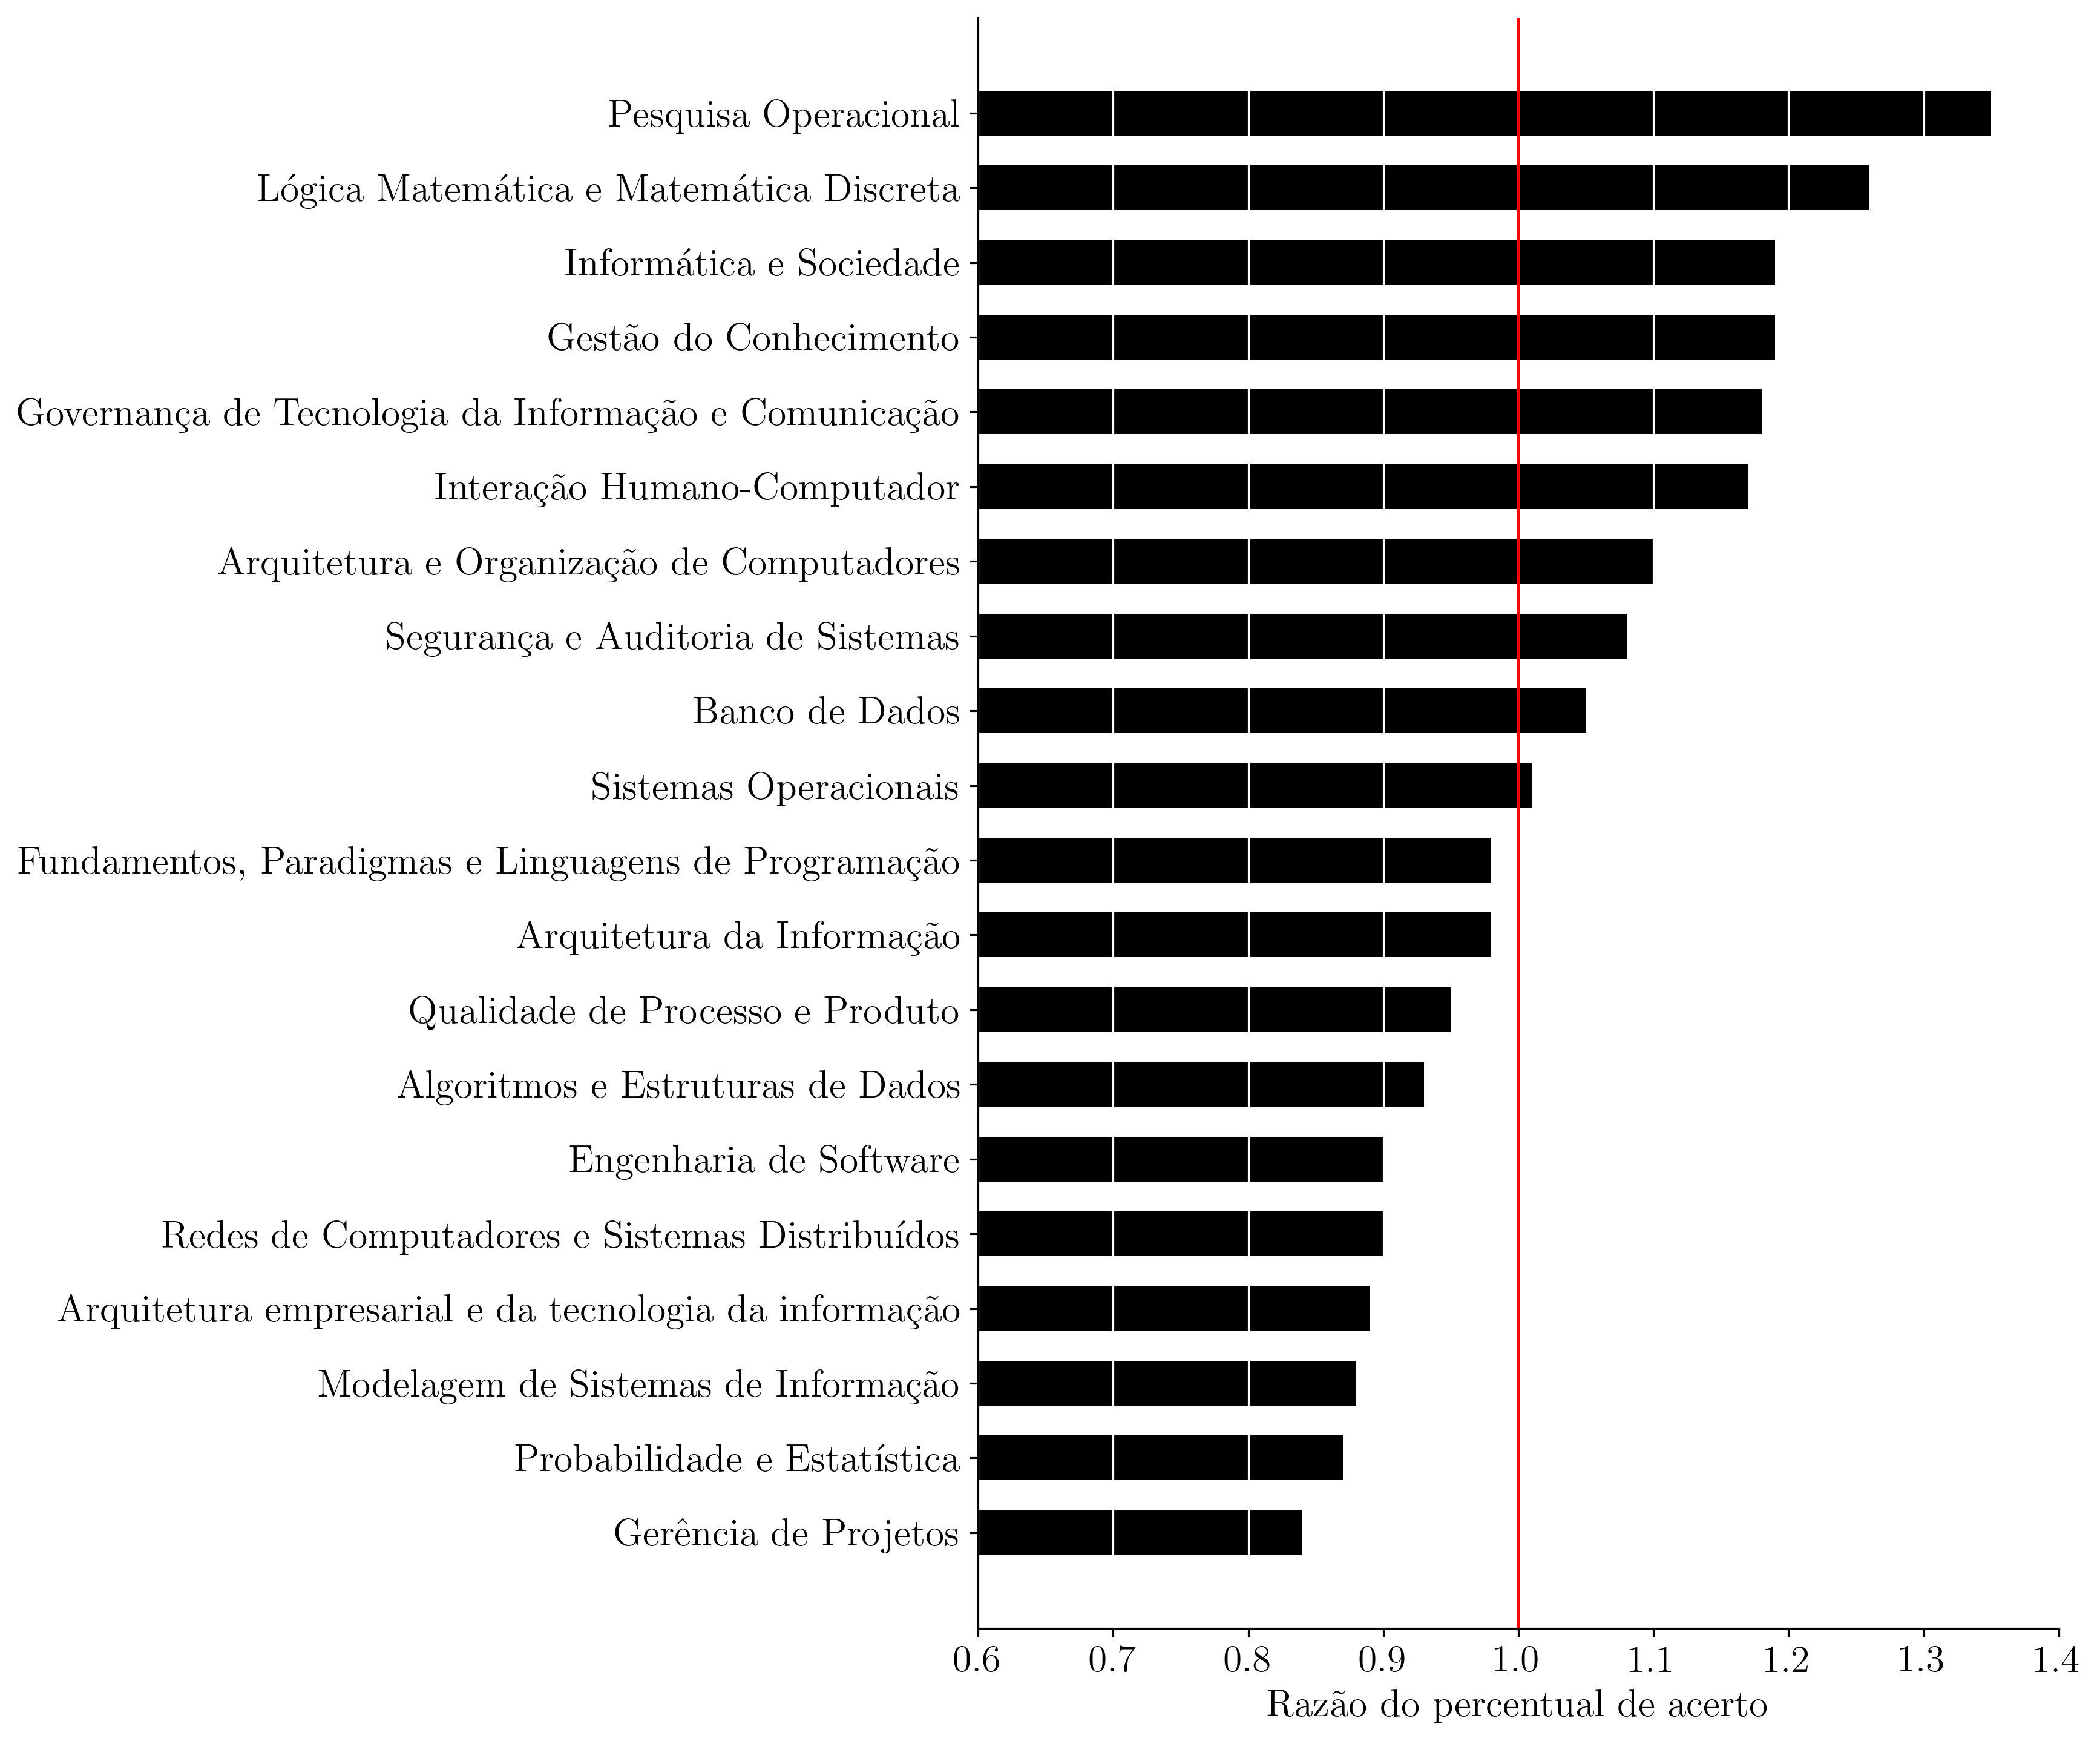

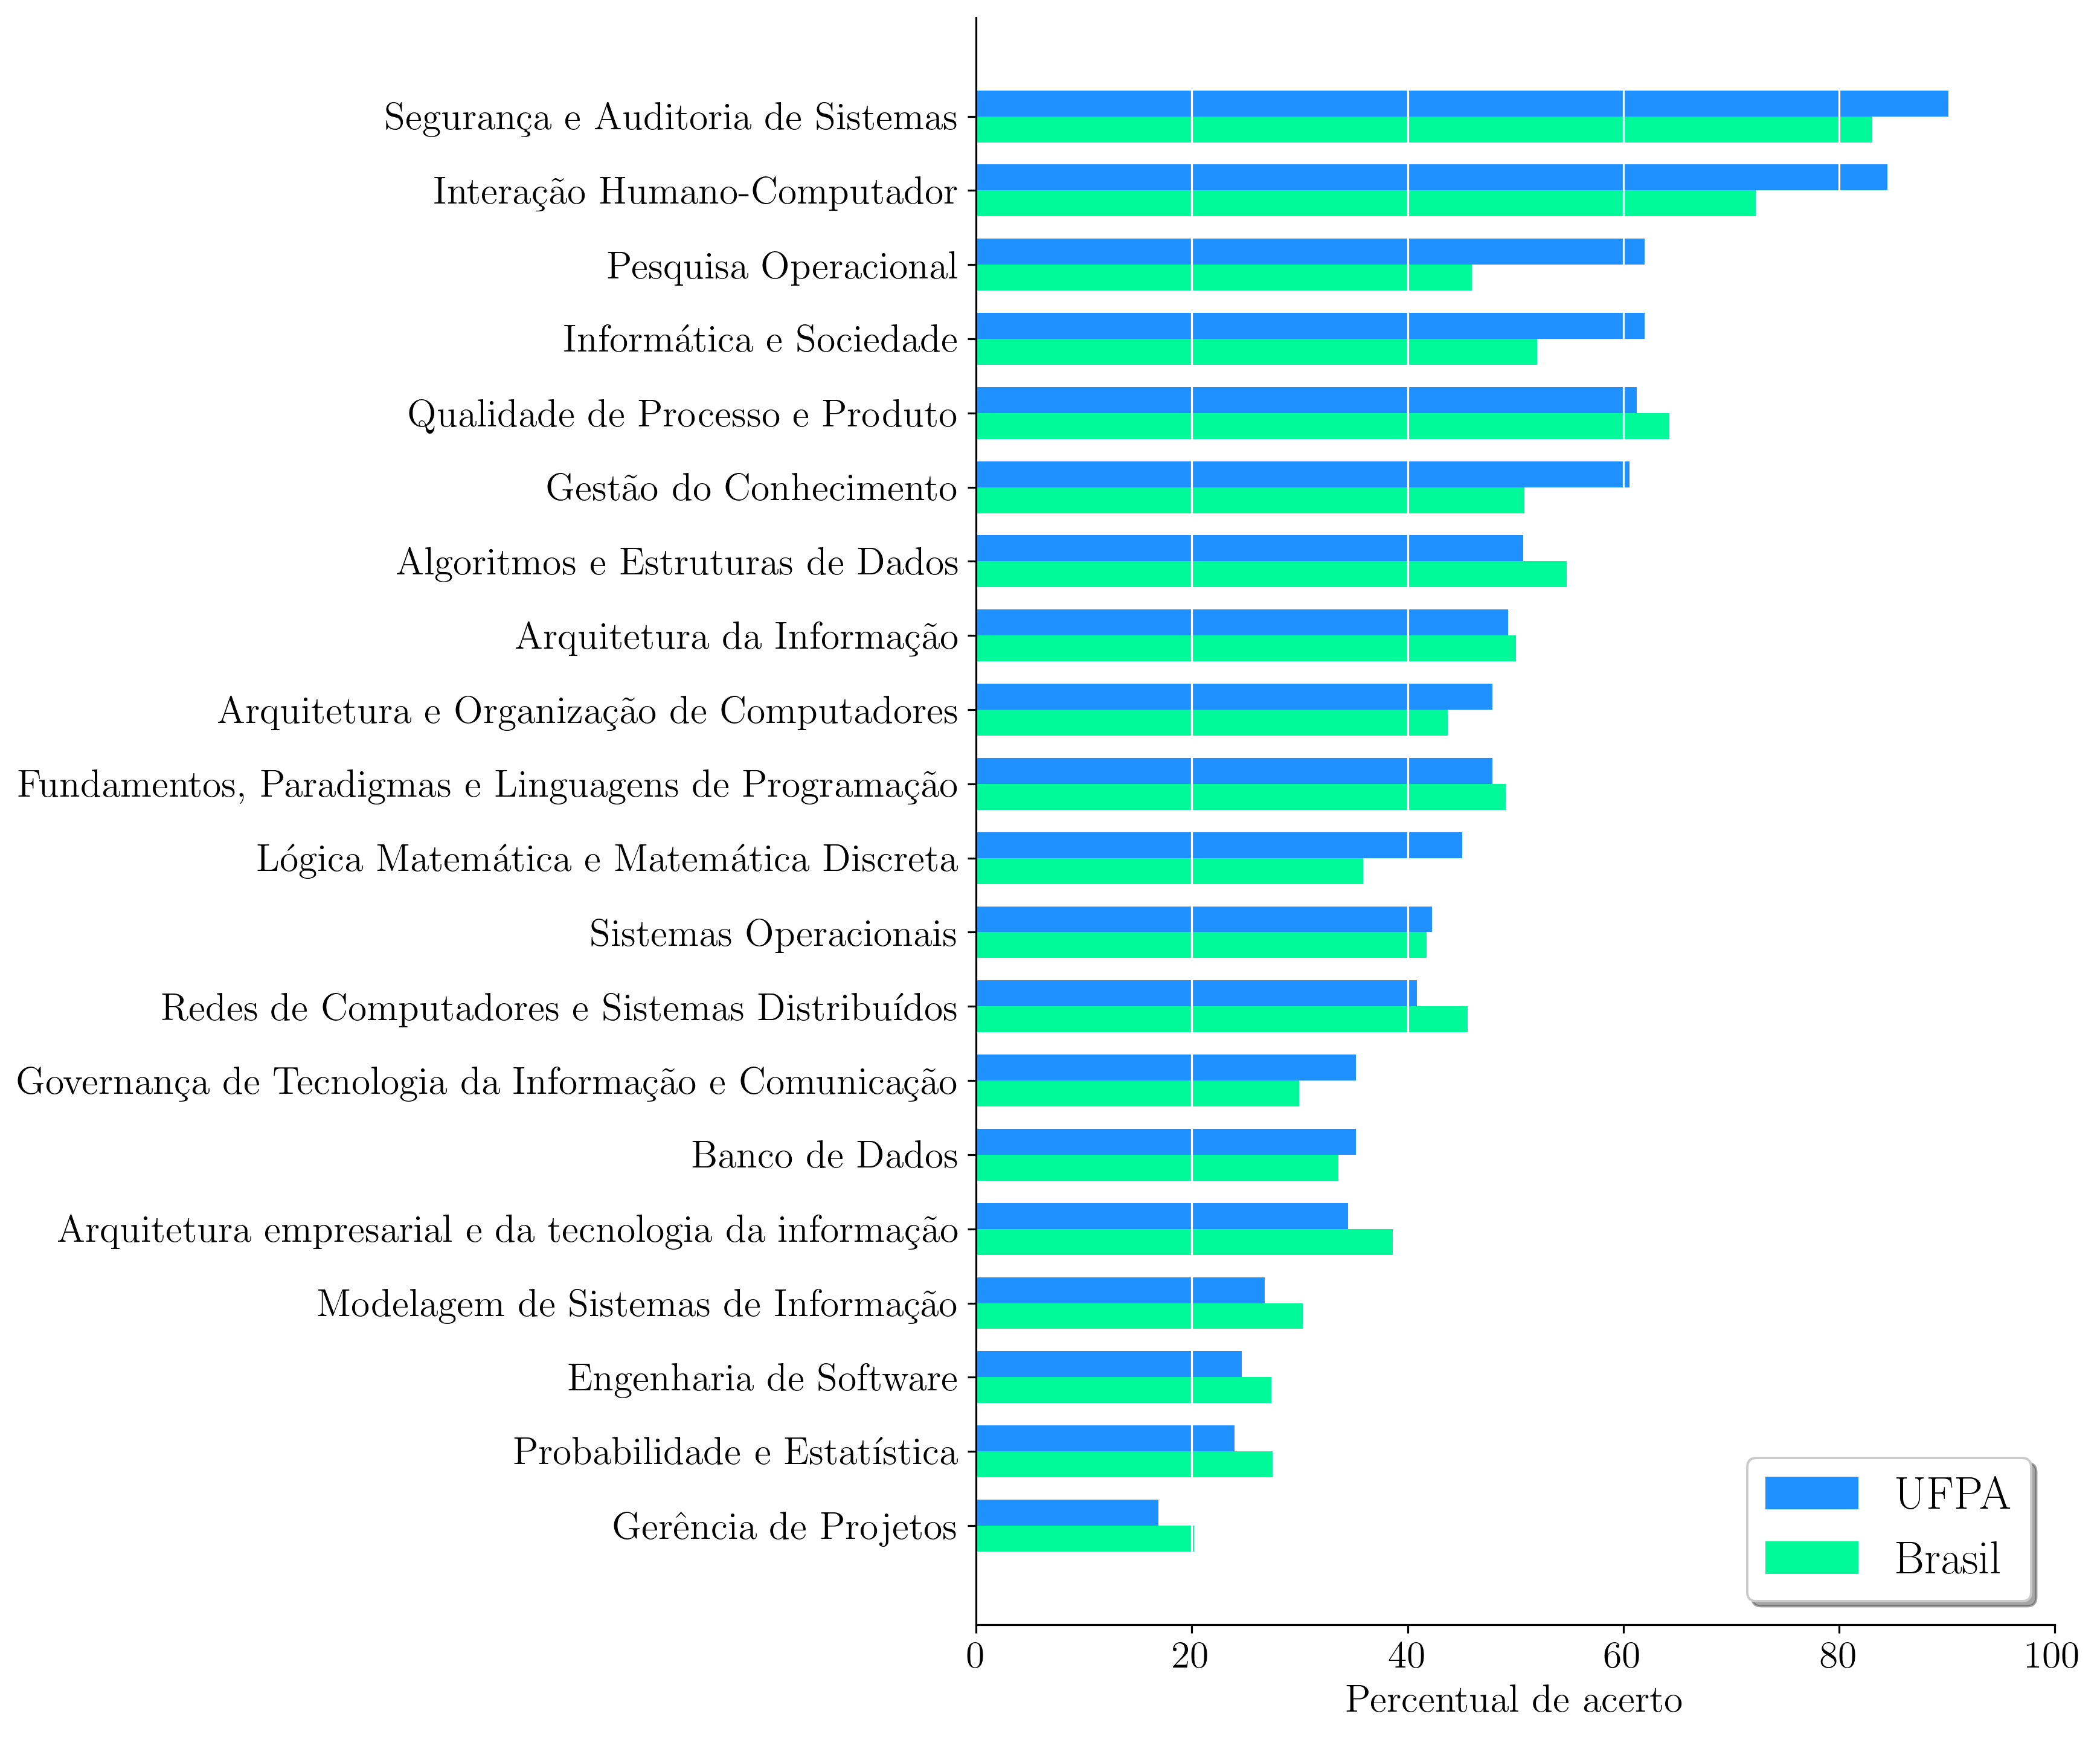

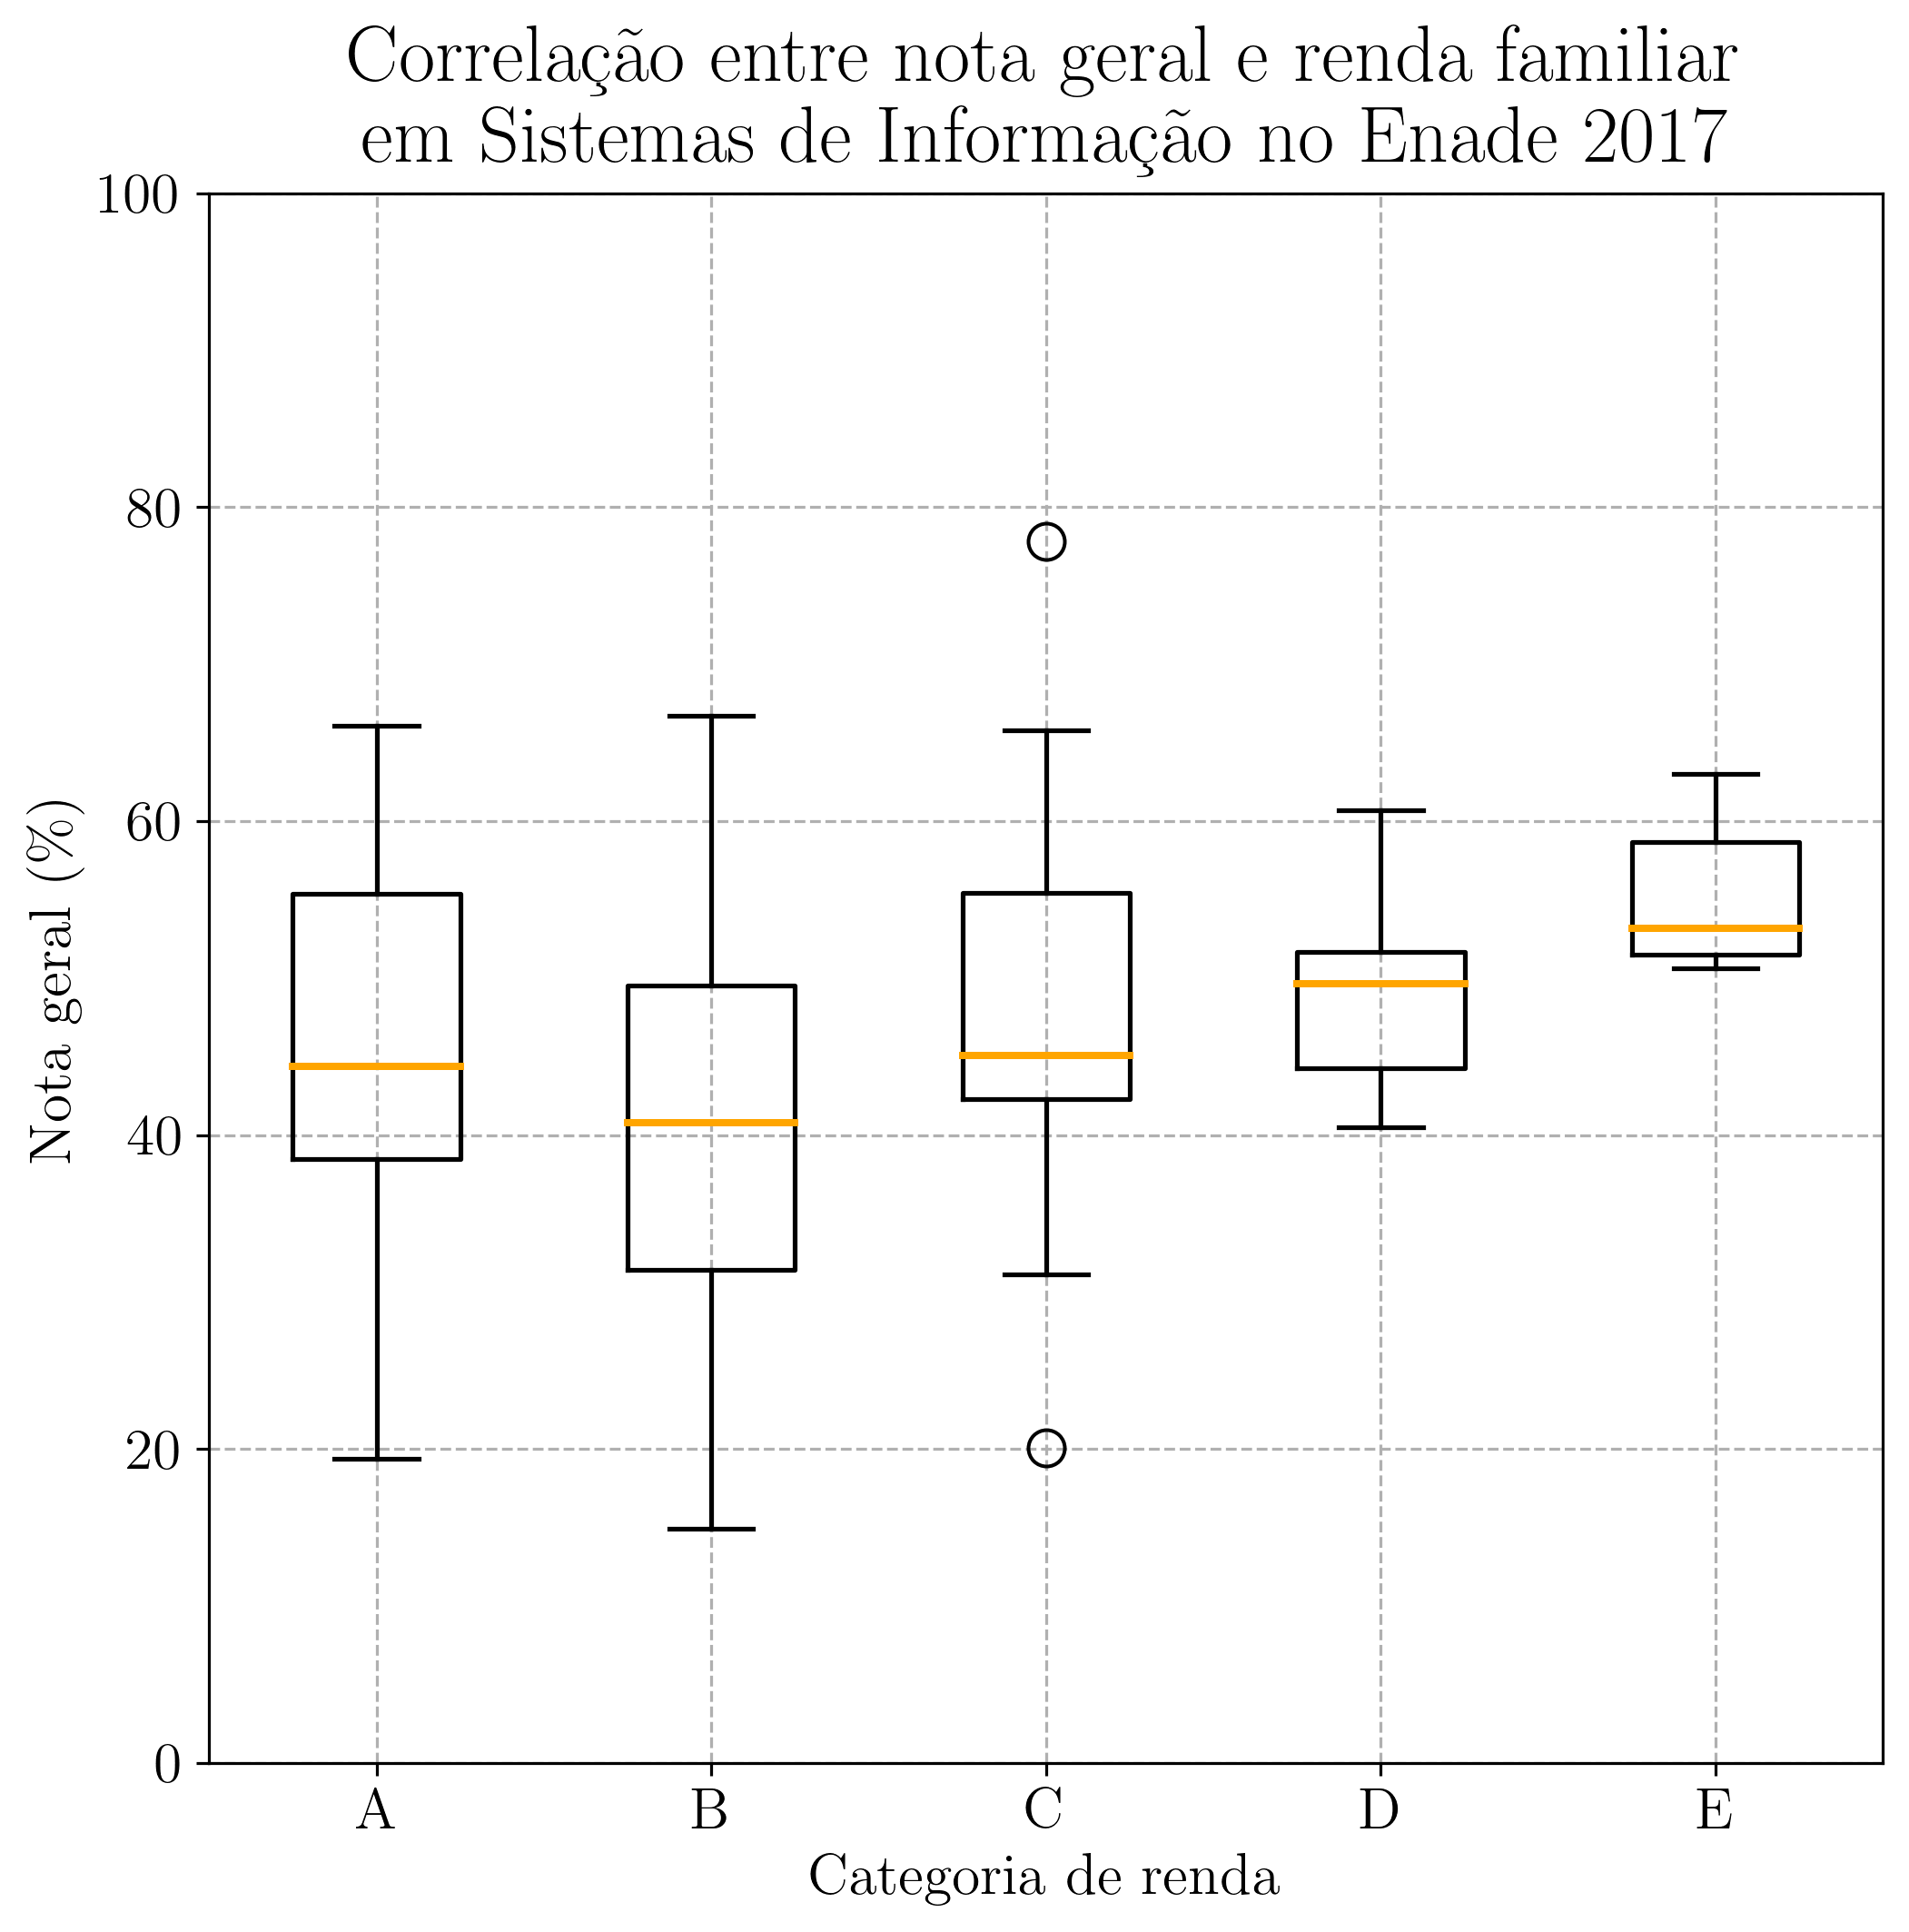

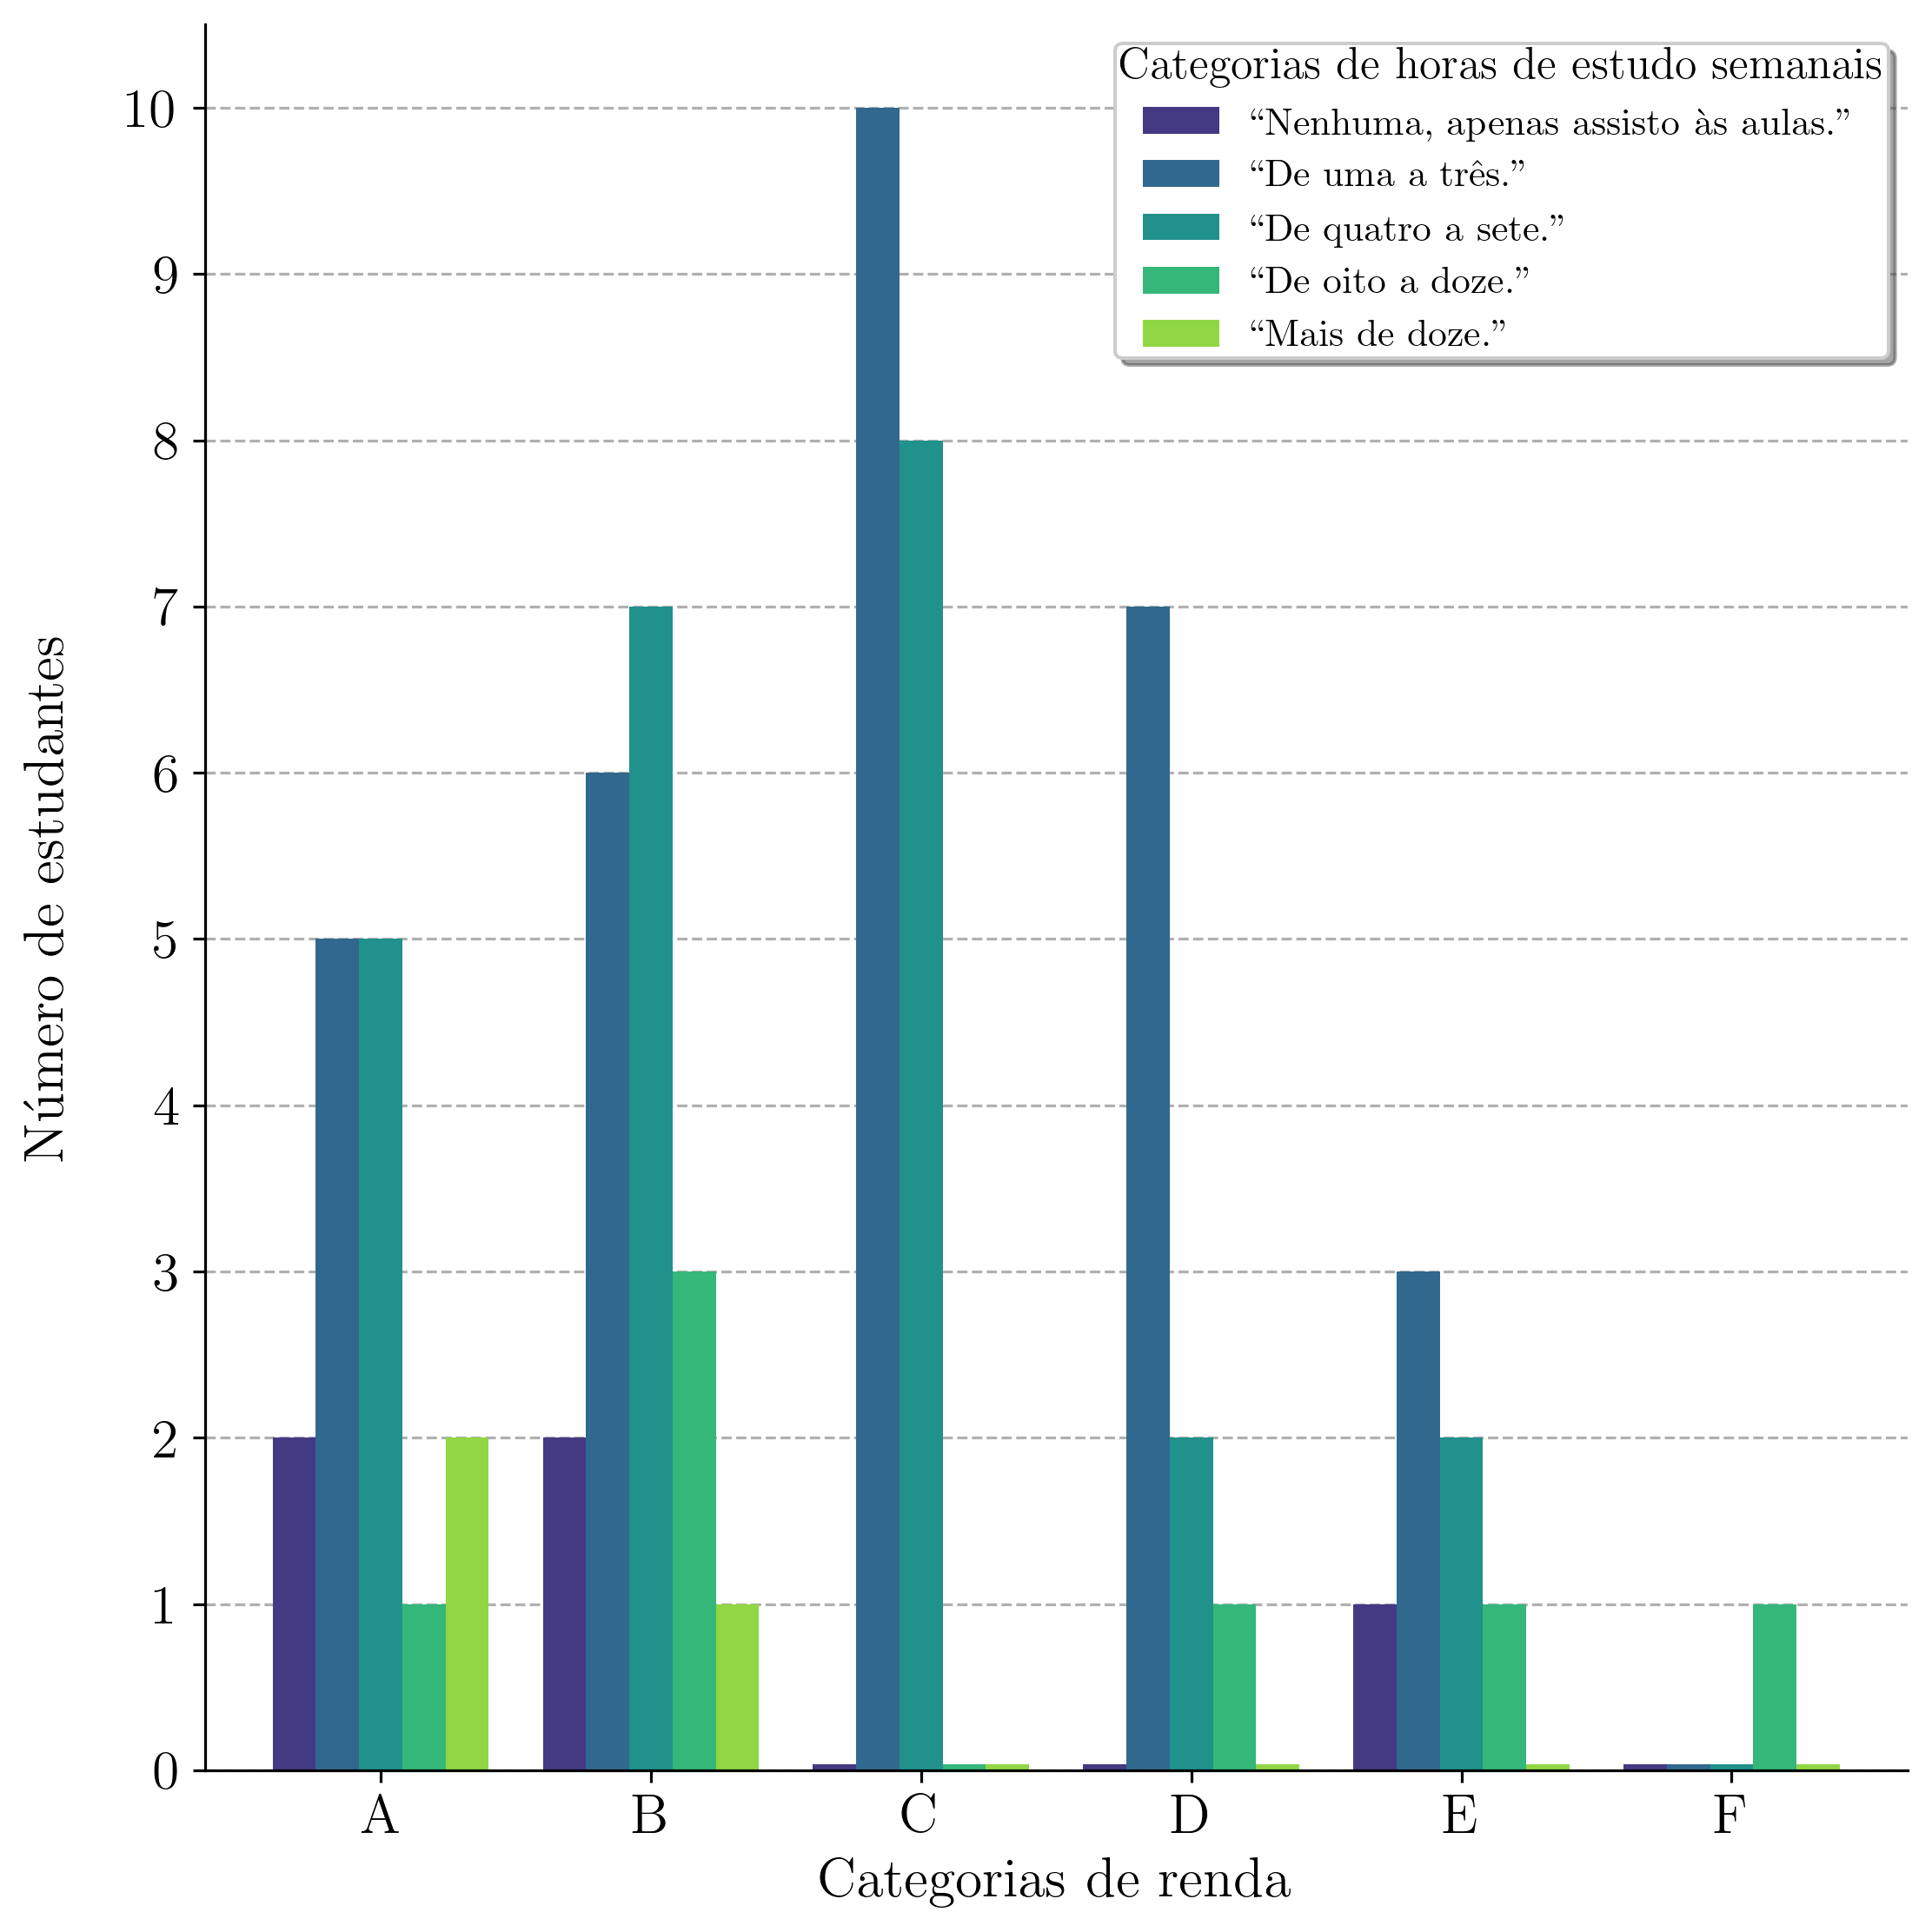

In [60]:
#Bloco de inicialização
if __name__ == '__main__':

    print("="*66)
    print("Análise comparativa de desempenho dos cursos do ICEN no ENADE 2017")
    print("="*66)

    print("Códigos dos cursos:\n")

    for k, v in COURSE_CODES.items():
        print(f"{v[0]}:   \t{k}", end='\n')

    try:
        course_code = int(input("\nInsira um código de curso: "))

    except ValueError:
        print("\nCódigo inválido inserido.")

    else:
        try:
            plot_performance_graph(course_code, ratio_graph=True)
            plot_income_grade_graph(course_code)
            plot_study_hours_income_graph(course_code)
            show_best_hei_ranking_table(course_code, public_only=True, to_latex=False)

        except KeyError:
           print("\nCódigo inválido inserido.")
